# Design MERFISH for MF3

by Pu Zheng

2023.8.20

In [1]:
import os, sys, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")

3697101


## Master folder
folder storing all the libraries

In [2]:
library_master_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes/'
# label
label_key = 'annotation'

## References:

GRCm39:
https://ftp.ensembl.org/pub/release-109/fasta/mus_musculus/ 

In [3]:
reference_folder = r'/lab/solexa_weissman/puzheng/References'
print(os.listdir(os.path.join(reference_folder, 'GRCm39', 'Transcriptome')))

['Mus_musculus.GRCm39.ncrna.fa', 'rtRNA_15.table', '.DS_Store', 'Mus_musculus.GRCm39.cdna.all.fa', 'transcriptome_17.table', 'Mus_musculus.GRCm39.109.gff3']


# Define design parameters

## Folders

In [4]:
# Define the output files
library_folder = os.path.join(library_master_folder, 'Brain_MS_immune', 'MF3-msBrain_immune_redesign')
print(f"- library will be saved in: {library_folder}")
if not os.path.exists(library_folder):
    os.makedirs(library_folder)
    print(f"-- create library_folder: {library_folder}")
probe_output_file = os.path.join(library_folder, 'designed_probes.csv')
print(f"-- library savefile: {probe_output_file}")
probe_output_idt_file = os.path.join(library_folder, 'designed_probes_idt_oPool.xlsx')
print(f"-- library IDT format savefile: {probe_output_idt_file}")

- library will be saved in: /lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF3-msBrain_immune_redesign
-- library savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF3-msBrain_immune_redesign/designed_probes.csv
-- library IDT format savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF3-msBrain_immune_redesign/designed_probes_idt_oPool.xlsx


## Input files:

In [5]:
library_folder

'/lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF3-msBrain_immune_redesign'

In [6]:
# The output codebook filename
codebook_file = os.path.join(library_folder, 'codebook.csv')

# gene mean expression
target_gene_mean_exp_filename = os.path.join(library_folder, 'marker_gene_mean_exp.csv')
# marker genes
kept_marker_gene_filename = os.path.join(library_folder, 'candidate_marker_gene_info.csv')

# readout file
readout_savefile = os.path.join(library_folder, 'readouts.csv')


You could also download an example data from:

http://zhuang.harvard.edu/merfish.html

In [7]:
# Define transcriptome reference
mRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome', 
                                      r'Mus_musculus.GRCm39.cdna.all.fa')
ncRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.ncrna.fa')
gff3_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.109.gff3')

# Define readout sequences
readout_fasta_file = os.path.join(reference_folder, 'Readouts',
                                  r'MERFISH_readouts.fasta')
if os.path.isfile(readout_fasta_file):
    print("readout_fasta_file exists")
else:
    print("readout_fasta_file doesn't exist")
    
# Define primer sequences
forward_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'forward_primers_keep.fasta')
reverse_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'reverse_primers_keep.fasta')
                                   #r'T7_reverse_primers.fasta')
selected_primers_file = os.path.join(library_folder, 'selected_primers.csv')

print(os.path.isfile(forward_primer_file), os.path.isfile(reverse_primer_file))
# Define FPKM reference (Not necessary for smFISH)
fpkm_tracking_file = os.path.join(library_folder, r'isoforms.fpkm_tracking')

readout_fasta_file exists
True True


## Packages

for MERFISH probe design, please refer to package: 
https://github.com/zhengpuas47/MERFISH_probe_design

In [8]:
import numpy as np
import pandas as pd

from IPython.display import display

import MERFISH_probe_design.IO.file_io as fio
import MERFISH_probe_design.probe_design.probe_dict as p_d
import MERFISH_probe_design.probe_design.OTTable_dict as ot
import MERFISH_probe_design.probe_design.readout_sequences as rs
import MERFISH_probe_design.probe_design.probe_selection as ps
import MERFISH_probe_design.probe_design.quality_check as qc
from MERFISH_probe_design.probe_design import filters
from MERFISH_probe_design.probe_design import plot
from MERFISH_probe_design.probe_design import primer_design

# Design targeting sequences

## Load required parameters

In [9]:
%%time
# Load the transcriptome as a pandas data frame
cdna = fio.load_transcriptome(mRNA_fasta_file, None)
ncrna = fio.load_transcriptome(ncRNA_fasta_file, None)
transcriptome = pd.concat([cdna, ncrna])
#transcriptome = fio.load_transcriptome(mRNA_fasta_file, fpkm_tracking_file) #MERFISH version

# Make sure that the transcriptome data frame has the standard column names.
# The standard columns are: transcript_id, sequence, gene_id, gene_short_name and FPKM.
# Also remove the non-standard columns for clarity.
transcriptome = qc.check_and_standardize_transcriptome(transcriptome, remove_non_standard_columns=True)

# This FPKM data is not for our cell type of interest. So set the FPKMs to be all 1.
transcriptome['FPKM'] = 1

Loaded 116912 transcripts.
116912
Loaded 29245 transcripts.
29245
CPU times: user 2.55 s, sys: 407 ms, total: 2.95 s
Wall time: 2.95 s


# Load gene-selection

In [10]:
# save
print(f"Loading mean_exp for target genes: {target_gene_mean_exp_filename}")
target_gene_mean_exp_df = pd.read_csv(target_gene_mean_exp_filename)
target_gene_mean_exp_df = target_gene_mean_exp_df.set_index(target_gene_mean_exp_df.columns[0])

Loading mean_exp for target genes: /lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF3-msBrain_immune_redesign/marker_gene_mean_exp.csv


In [11]:
transcriptome[np.array([('ENSMUSG00000067235' in str(_g)) 
                        for _g in transcriptome['gene_id']])]

,transcript_id,sequence,FPKM,gene_id,gene_short_name
76718,ENSMUST00000068291.7,AGACGCCCCGGATCCCAGATGGGGGCGATGGCGCCGCGCACGCTGC...,1,ENSMUSG00000067235.15,None
76719,ENSMUST00000174525.8,AGACGCCCCGGATCCCAGATGGGGGCGATGGCGCCGCGCACGCTGC...,1,ENSMUSG00000067235.15,None
76720,ENSMUST00000174589.2,CGGATCCCAGATGGGGGCGATGGCGCCGCGCACGCTGCTCCTGCTG...,1,ENSMUSG00000067235.15,None


In [12]:
transcriptome.loc[transcriptome['gene_short_name'] == 'Septin11']

,transcript_id,sequence,FPKM,gene_id,gene_short_name
97184,ENSMUST00000074733.11,AGATGCGGCTGGAGGCGCGCGGGAGCCGGGCGCGAGCAGGGCGCAG...,1,ENSMUSG00000058013.12,Septin11
97185,ENSMUST00000201377.2,GATGCGGCTGGAGGCGCGCGGGAGCCGGGCGCGAGCAGGGCGCAGC...,1,ENSMUSG00000058013.12,Septin11
97186,ENSMUST00000201700.4,GATGCGGCTGGAGGCGCGCGGGAGCCGGGCGCGAGCAGGGCGCAGC...,1,ENSMUSG00000058013.12,Septin11
97187,ENSMUST00000202196.4,GAGGCGCGCGGGAGCCGGGCGCGAGCAGGGCGCAGCCGCGAGGGAG...,1,ENSMUSG00000058013.12,Septin11
97188,ENSMUST00000202308.4,GCGCGCGGGAGCCGGGCGCGAGCAGGGCGCAGCCGCGAGGGAGGCG...,1,ENSMUSG00000058013.12,Septin11
97189,ENSMUST00000201421.4,AGCAGCAGCCAGTGTCGGTAAAGAGCAGCCAGAGCCACAGTCGCGA...,1,ENSMUSG00000058013.12,Septin11
97190,ENSMUST00000202415.4,AGTGTCGGTAAAGAGCAGCCAGAGCCACAGTCGCGATGGCCGTGGC...,1,ENSMUSG00000058013.12,Septin11
97191,ENSMUST00000202217.3,ATGGCCGTGGCGGTGGGGAGACCGAGTAATGAAGAGCTGCGAAACT...,1,ENSMUSG00000058013.12,Septin11
97192,ENSMUST00000201695.2,CTCCAGGAAAGCAACGTACGGCTGAAGCTAACAATCGTTGACACAG...,1,ENSMUSG00000058013.12,Septin11


In [13]:
# Modify transcriptome to add information:
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000037548.16', 'gene_short_name'] = 'H2-DMb2'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000037649.11', 'gene_short_name'] = 'H2-DMa'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000112023.2', 'gene_short_name'] = 'Lilr4b'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000079547.5', 'gene_short_name'] = 'H2-DMb1'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000060586.12', 'gene_short_name'] = 'H2-Eb1'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000073421.7', 'gene_short_name'] = 'H2-Ab1'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000036594.16', 'gene_short_name'] = 'H2-Aa'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000041538.17', 'gene_short_name'] = 'H2-Ob'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000067235.15', 'gene_short_name'] = 'H2-Q10'


# replace gene-list:
replace_dict = {'Tcrg-C1':'Trgc1', 'Tcrg-C2':'Trgc2', 'Tcrg-C4':'Trgc4', 'Sept1':'Septin1', 'H2afy':'Macroh2a2','Qk':'Qki',
                'Hist1h1b':'H1f5','Fam129b':'Niban2','Sept3':'Septin3',
                'Hist1h2ab':'H2ac4',
                'Il1f9':'Il36g','Cd163l1':'Scart1','Hist1h2af':'H2ac10',
                'Fam71f2':'Garin1a','Hist1h3c':'H3c3','Ero1l':'Ero1a',
                'Ero1lb':'Ero1b','Pakap-1':'Pakap',
                'Fam129c':'Niban3',
                'Gm14548':'Pira12','Ptprg':'PTPRG',
                'Mpp6':'Pals2', 'Sept11':'Septin11',
               }
target_gene_mean_exp_df.rename(index=replace_dict, inplace=True)

# check if all exists
for _gene in list(target_gene_mean_exp_df.index):
    # Let's have a look at the transcripts of the FLNA gene
    _transcripts = transcriptome[transcriptome['gene_short_name'] == _gene].sort_values('FPKM', ascending=False)
    if len(_transcripts) == 0:
        print(_gene, len(_transcripts))

In [14]:
gene_ids = target_gene_mean_exp_df.index.values

In [15]:
np.save(os.path.join(library_folder, 'replace_dict.npy'), replace_dict, allow_pickle=True)

In [16]:
# Initialize the probe dictionary which is the carrier of the probes throught the design process.
probe_dict = p_d.init_probe_dict(gene_ids, transcriptome, 'gene_short_name', K=30)
#if len(transcript_ids) == len(gene_ids):
#    # Select the transcripts that we want to target
#    # The target transcripts are already defined in the codebook
#    p_d.select_transcripts_by_ids(probe_dict, transcript_ids)
# Init
p_d.print_probe_dict(probe_dict)

Found 2531 transcripts for 426 target genes.
Gene	Transcript	N_probes
Trbc1
	ENSMUST00000192856.6	708
	ENSMUST00000103291.2	483
Trbc2
	ENSMUST00000103299.3	663
Trac
	ENSMUST00000198398.5	906
	ENSMUST00000103740.2	384
Trgc1
	ENSMUST00000103558.3	895
Trgc2
	ENSMUST00000103561.3	885
Trgc4
	ENSMUST00000179181.3	956
Iglc1
	ENSMUST00000200568.2	425
Gramd3
	ENSMUST00000237355.2	2600
	ENSMUST00000237422.2	2324
	ENSMUST00000235794.2	1555
	ENSMUST00000237716.2	3717
	ENSMUST00000070166.6	2576
Ctsf
	ENSMUST00000119694.3	1951
	ENSMUST00000237755.2	1659
	ENSMUST00000237504.2	431
	ENSMUST00000237784.2	2064
	ENSMUST00000237011.2	372
	ENSMUST00000236406.2	765
	ENSMUST00000235464.2	663
	ENSMUST00000237401.2	643
	ENSMUST00000235931.2	1206
	ENSMUST00000235264.2	698
	ENSMUST00000238118.2	579
	ENSMUST00000235354.2	462
Arhgap5
	ENSMUST00000218755.2	1640
	ENSMUST00000219443.2	9294
	ENSMUST00000217820.2	2303
	ENSMUST00000110725.2	5168
Dach1
	ENSMUST00000071533.13	5190
	ENSMUST00000069334.8	5034
	ENSMUST0000015

# First round design

To determine number of probes

### Calculate and filter by probe GC

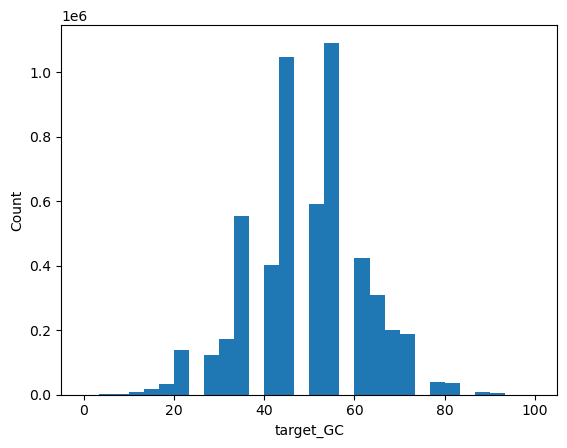

In [17]:
# Calculate and plot the GC contents of the target regions
filters.calc_gc_for_probe_dict(probe_dict, column_key_seq='target_sequence', column_key_write='target_GC')
plot.plot_hist(probe_dict, column_key='target_GC')

Trbc1
	ENSMUST00000192856.6: 513 / 708 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000103291.2: 454 / 483 probes passed the filter 40 < target_GC <  70.
Trbc2
	ENSMUST00000103299.3: 555 / 663 probes passed the filter 40 < target_GC <  70.
Trac
	ENSMUST00000198398.5: 660 / 906 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000103740.2: 325 / 384 probes passed the filter 40 < target_GC <  70.
Trgc1
	ENSMUST00000103558.3: 530 / 895 probes passed the filter 40 < target_GC <  70.
Trgc2
	ENSMUST00000103561.3: 522 / 885 probes passed the filter 40 < target_GC <  70.
Trgc4
	ENSMUST00000179181.3: 513 / 956 probes passed the filter 40 < target_GC <  70.
Iglc1
	ENSMUST00000200568.2: 392 / 425 probes passed the filter 40 < target_GC <  70.
Gramd3
	ENSMUST00000237355.2: 1730 / 2600 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000237422.2: 1604 / 2324 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000235794.2: 1039 / 1555 probes passed the filter 40 < tar

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000212871.2: 671 / 1506 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000212500.2: 153 / 241 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000212849.2: 310 / 406 probes passed the filter 40 < target_GC <  70.
C1galt1c1
	ENSMUST00000058265.8: 594 / 1420 probes passed the filter 40 < target_GC <  70.
Clec4d
	ENSMUST00000204826.3: 472 / 881 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000032240.4: 591 / 1294 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000203421.2: 287 / 564 probes passed the filter 40 < target_GC <  70.
Gtf2h2
	ENSMUST00000145266.8: 876 / 1601 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000231227.2: 249 / 351 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000232450.2: 256 / 489 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000232447.2: 209 / 413 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000066984.14: 682 / 1627 probes passed the filter 40 < target_GC <  70.
	ENSMUST00

	ENSMUST00000145977.8: 235 / 244 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000145818.2: 524 / 562 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000151594.8: 1501 / 1618 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000130378.2: 603 / 917 probes passed the filter 40 < target_GC <  70.
Tmem154
	ENSMUST00000107682.2: 2087 / 3313 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000134890.8: 892 / 1546 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000129417.2: 300 / 371 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000128344.2: 272 / 428 probes passed the filter 40 < target_GC <  70.
Lag3
	ENSMUST00000032217.2: 1531 / 1972 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000139571.2: 365 / 397 probes passed the filter 40 < target_GC <  70.
Myof
	ENSMUST00000224560.2: 484 / 834 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000041475.16: 5151 / 6873 probes passed the filter 40 < target_GC <  70.
	ENSMUST0000

	ENSMUST00000027777.12: 3129 / 3844 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000194434.2: 241 / 327 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000191639.2: 468 / 531 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000192411.2: 334 / 524 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000193238.2: 665 / 842 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000191833.2: 566 / 730 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000195560.2: 349 / 447 probes passed the filter 40 < target_GC <  70.
Parl
	ENSMUST00000152887.3: 977 / 1326 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000136252.8: 910 / 1333 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000048642.15: 934 / 1319 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000232036.2: 834 / 1217 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000232484.2: 566 / 819 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000155832.2: 364 

	ENSMUST00000140843.9: 12434 / 15370 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000229722.2: 1555 / 2623 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000070420.10: 3919 / 4845 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000154193.8: 4163 / 5348 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000141917.2: 1175 / 1731 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000129384.2: 1437 / 1841 probes passed the filter 40 < target_GC <  70.
Tmtc2
	ENSMUST00000130665.2: 1071 / 2750 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000061506.9: 3339 / 5600 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000147997.2: 670 / 895 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000133441.2: 587 / 660 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000143691.2: 2591 / 4437 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000139741.2: 397 / 595 probes passed the filter 40 < target_GC <  70.
Gm8369
	ENSMU

	ENSMUST00000202031.4: 1058 / 1835 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000202279.4: 607 / 920 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000202291.3: 307 / 380 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000200840.2: 879 / 1342 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000201319.2: 671 / 1092 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000200926.2: 570 / 718 probes passed the filter 40 < target_GC <  70.
Il15ra
	ENSMUST00000138349.8: 1441 / 1907 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000091456.12: 795 / 892 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000135341.8: 1223 / 1516 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000128156.9: 1291 / 1595 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000130245.2: 441 / 478 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000191662.6: 1074 / 1379 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000148748.

	ENSMUST00000033053.8: 3392 / 4017 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000205460.2: 968 / 1186 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000205408.2: 247 / 323 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000206396.2: 454 / 515 probes passed the filter 40 < target_GC <  70.
Anapc13
	ENSMUST00000190279.7: 376 / 560 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000188398.7: 517 / 698 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000038673.14: 327 / 382 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000186693.2: 467 / 566 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000190354.2: 818 / 1187 probes passed the filter 40 < target_GC <  70.
Comt
	ENSMUST00000165430.8: 1605 / 1949 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000115609.10: 1314 / 1837 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000000335.12: 1054 / 1368 probes passed the filter 40 < target_GC <  70.
	ENSMUST000001

	ENSMUST00000169591.8: 1875 / 2213 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000003416.15: 1861 / 2198 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000165515.8: 1722 / 2049 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000237245.2: 1706 / 2036 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000170956.8: 686 / 775 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000164628.2: 438 / 469 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000169252.8: 702 / 879 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000163736.2: 398 / 457 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000168346.2: 799 / 1011 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000168285.2: 724 / 862 probes passed the filter 40 < target_GC <  70.
Alox5
	ENSMUST00000026795.13: 2296 / 2792 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000167447.8: 3083 / 3547 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000169625

	ENSMUST00000238338.2: 452 / 615 probes passed the filter 40 < target_GC <  70.
Vars
	ENSMUST00000087315.14: 3203 / 4108 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000173584.8: 3180 / 4019 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000174260.8: 449 / 790 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000172570.2: 355 / 394 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000172637.8: 3245 / 3702 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000172656.2: 350 / 446 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000172741.2: 283 / 318 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000173911.2: 662 / 717 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000173336.2: 455 / 528 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000172999.2: 766 / 777 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000173142.2: 341 / 359 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000173302.2: 661 /

	ENSMUST00000191247.7: 1967 / 3899 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000188252.7: 234 / 234 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000186822.2: 393 / 476 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000186804.2: 349 / 379 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000187406.7: 314 / 341 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000187420.7: 386 / 422 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000186755.2: 1550 / 2763 probes passed the filter 40 < target_GC <  70.
Mrpl58
	ENSMUST00000153983.8: 1828 / 2567 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000103036.5: 586 / 720 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000106539.10: 1782 / 2493 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000128632.8: 582 / 776 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000122946.8: 228 / 334 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000133192.2: 2

	ENSMUST00000233901.2: 749 / 1328 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000233877.2: 955 / 1587 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000186007.4: 854 / 1519 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000191539.2: 164 / 298 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000241039.1: 447 / 917 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000242758.1: 407 / 548 probes passed the filter 40 < target_GC <  70.
4933421O10Rik
	ENSMUST00000155691.2: 2247 / 3818 probes passed the filter 40 < target_GC <  70.
Lncpint
	ENSMUST00000230091.2: 976 / 1149 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000229076.2: 1068 / 1603 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000229711.2: 961 / 1418 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000229299.2: 201 / 231 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000229116.2: 528 / 932 probes passed the filter 40 < target_GC <  70.
	ENSMUST0

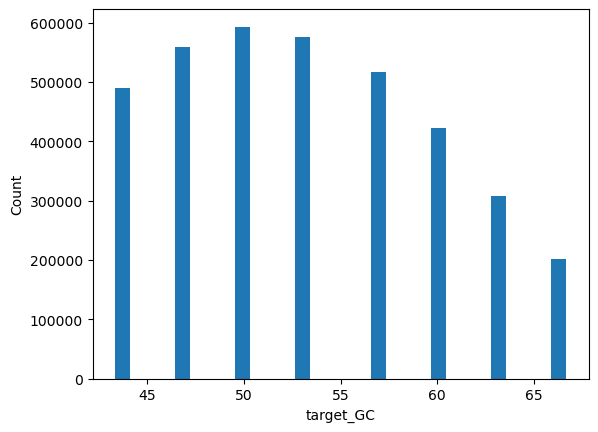

In [18]:
# Filter GC cotent and plot the GC content after filtering
filters.filter_probe_dict_by_metric(probe_dict, 'target_GC', lower_bound=40, upper_bound=70)
plot.plot_hist(probe_dict, column_key='target_GC', bins=30)

### Calculate and filter by probe Tm

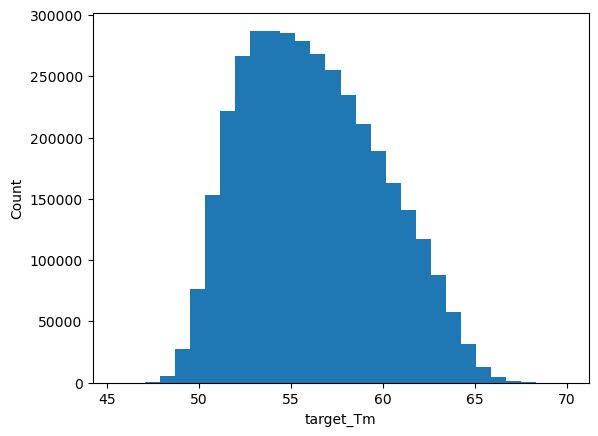

In [19]:
# Calculate and plot the melting-temperatures (Tm)
filters.calc_tm_for_probe_dict(probe_dict, Na_conc=390, fmd_percentile=30, probe_conc=5,
                              column_key_seq='target_sequence', column_key_write='target_Tm')
plot.plot_hist(probe_dict, column_key='target_Tm')

Trbc1
	ENSMUST00000192856.6: 504 / 513 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000103291.2: 453 / 454 probes passed the filter 50 < target_Tm <  65.
Trbc2
	ENSMUST00000103299.3: 548 / 555 probes passed the filter 50 < target_Tm <  65.
Trac
	ENSMUST00000198398.5: 653 / 660 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000103740.2: 321 / 325 probes passed the filter 50 < target_Tm <  65.
Trgc1
	ENSMUST00000103558.3: 503 / 530 probes passed the filter 50 < target_Tm <  65.
Trgc2
	ENSMUST00000103561.3: 501 / 522 probes passed the filter 50 < target_Tm <  65.
Trgc4
	ENSMUST00000179181.3: 497 / 513 probes passed the filter 50 < target_Tm <  65.
Iglc1
	ENSMUST00000200568.2: 392 / 392 probes passed the filter 50 < target_Tm <  65.
Gramd3
	ENSMUST00000237355.2: 1692 / 1730 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000237422.2: 1568 / 1604 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000235794.2: 1001 / 1039 probes passed the filter 50 < tar

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000206871.2: 405 / 411 probes passed the filter 50 < target_Tm <  65.
Abtb1
	ENSMUST00000032169.8: 1607 / 1616 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000203137.3: 1538 / 1547 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000203272.3: 3671 / 3757 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000204560.3: 630 / 634 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000203120.3: 386 / 387 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000204327.3: 522 / 523 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000205082.3: 539 / 540 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000204458.3: 708 / 713 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000203514.3: 478 / 483 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000203864.3: 565 / 570 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000203460.2: 622 / 628 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000204932.2: 343 /

	ENSMUST00000034026.10: 651 / 669 probes passed the filter 50 < target_Tm <  65.
Foxp3
	ENSMUST00000234896.2: 415 / 434 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000234363.2: 1824 / 1877 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000234479.2: 1314 / 1356 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000235116.2: 1298 / 1340 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000115739.9: 3237 / 3326 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000234574.2: 1243 / 1288 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000115740.9: 3299 / 3397 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000115738.8: 3156 / 3245 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000234015.2: 995 / 1022 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000045566.7: 3046 / 3136 probes passed the filter 50 < target_Tm <  65.
St3gal6
	ENSMUST00000137035.8: 1958 / 2022 probes passed the filter 50 < target_Tm <  65.
	ENSMU

	ENSMUST00000034017.9: 1702 / 1749 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000210166.2: 2509 / 2570 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000209919.2: 2245 / 2330 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000209458.2: 553 / 571 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000209544.2: 227 / 234 probes passed the filter 50 < target_Tm <  65.
Rab3il1
	ENSMUST00000121418.8: 2658 / 2691 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000137637.8: 456 / 457 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000149967.9: 2066 / 2097 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000113161.10: 3943 / 4012 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000238672.2: 4067 / 4140 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000117641.8: 1707 / 1730 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000144788.8: 1700 / 1733 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000

	ENSMUST00000009789.15: 2446 / 2501 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000092512.11: 1535 / 1565 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000105466.3: 1924 / 1969 probes passed the filter 50 < target_Tm <  65.
Arg2
	ENSMUST00000021550.7: 913 / 932 probes passed the filter 50 < target_Tm <  65.
Tet2
	ENSMUST00000098603.8: 5991 / 6109 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000199381.2: 3493 / 3549 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000196398.5: 6009 / 6125 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000197211.2: 2135 / 2176 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000198974.2: 279 / 287 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000199176.2: 1188 / 1236 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000200203.2: 749 / 778 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000197118.5: 348 / 350 probes passed the filter 50 < target_Tm <  65.
	ENSMUST0000

	ENSMUST00000181736.2: 870 / 913 probes passed the filter 50 < target_Tm <  65.
Ero1b
	ENSMUST00000221560.2: 1213 / 1244 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000071973.8: 2110 / 2164 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000220811.2: 1728 / 1779 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000221739.2: 985 / 1010 probes passed the filter 50 < target_Tm <  65.
Fpr1
	ENSMUST00000061516.8: 951 / 973 probes passed the filter 50 < target_Tm <  65.
Ccl22
	ENSMUST00000034231.4: 1785 / 1824 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000156137.2: 355 / 359 probes passed the filter 50 < target_Tm <  65.
Rabgap1l
	ENSMUST00000028052.12: 2162 / 2242 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000192019.6: 243 / 246 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000191909.6: 389 / 395 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000193185.6: 493 / 497 probes passed the filter 50 < target_Tm <  65.
	E

	ENSMUST00000188398.7: 504 / 517 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000038673.14: 323 / 327 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000186693.2: 450 / 467 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000190354.2: 782 / 818 probes passed the filter 50 < target_Tm <  65.
Comt
	ENSMUST00000165430.8: 1589 / 1605 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000115609.10: 1296 / 1314 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000000335.12: 1039 / 1054 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000147720.3: 677 / 680 probes passed the filter 50 < target_Tm <  65.
Rtl5
	ENSMUST00000113631.2: 3652 / 3760 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000119076.9: 3443 / 3539 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000139878.2: 337 / 345 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000188731.2: 3443 / 3539 probes passed the filter 50 < target_Tm <  65.
Nos2
	ENSMUST00

	ENSMUST00000016638.8: 1678 / 1725 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000110815.9: 1760 / 1814 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000194458.2: 1459 / 1517 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000195092.2: 1447 / 1502 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000194036.2: 410 / 422 probes passed the filter 50 < target_Tm <  65.
Nrp2
	ENSMUST00000126344.2: 1703 / 1792 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000102822.9: 4668 / 4803 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000075144.12: 4675 / 4809 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000027112.13: 3218 / 3292 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000114155.8: 4489 / 4634 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000063594.13: 4562 / 4695 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000114157.3: 4563 / 4696 probes passed the filter 50 < target_Tm <  65.
Xcl1
	ENSM

	ENSMUST00000095027.9: 4131 / 4215 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000238906.2: 4184 / 4275 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000136641.3: 559 / 572 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000027250.14: 1167 / 1195 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000134963.2: 461 / 475 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000039827.14: 4163 / 4247 probes passed the filter 50 < target_Tm <  65.
Cxcl10
	ENSMUST00000201176.2: 1391 / 1435 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000038816.13: 661 / 666 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000118006.3: 948 / 980 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000138169.2: 301 / 302 probes passed the filter 50 < target_Tm <  65.
Il6
	ENSMUST00000026845.12: 383 / 390 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000199183.5: 977 / 1015 probes passed the filter 50 < target_Tm <  65.
	ENSMUST000001

	ENSMUST00000140474.8: 1093 / 1112 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000040250.15: 1777 / 1816 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000142223.8: 1122 / 1136 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000150646.2: 235 / 239 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000097458.4: 2228 / 2283 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000137174.2: 301 / 302 probes passed the filter 50 < target_Tm <  65.
Xbp1
	ENSMUST00000063084.16: 1364 / 1408 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000239150.2: 784 / 807 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000145588.2: 609 / 618 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000149623.8: 708 / 726 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000149159.3: 818 / 841 probes passed the filter 50 < target_Tm <  65.
Ldlrad3
	ENSMUST00000058790.12: 2401 / 2448 probes passed the filter 50 < target_Tm <  65.
	ENSMUST0000

	ENSMUST00000126024.2: 524 / 533 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000134296.8: 591 / 609 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000143269.2: 662 / 680 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000135513.2: 501 / 517 probes passed the filter 50 < target_Tm <  65.
Il13
	ENSMUST00000020650.2: 834 / 845 probes passed the filter 50 < target_Tm <  65.
Trim30b
	ENSMUST00000145982.2: 2283 / 2343 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000171830.2: 1232 / 1258 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000209729.2: 1232 / 1258 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000106831.3: 2272 / 2357 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000155961.2: 207 / 209 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000164410.2: 1672 / 1710 probes passed the filter 50 < target_Tm <  65.
Dpp4
	ENSMUST00000047812.8: 2523 / 2596 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00

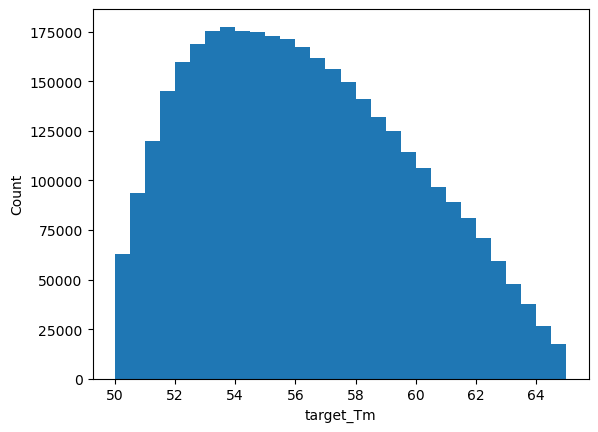

In [20]:
# Filter by Tm
# NOTE: here we used a higher upper bound for GC content and Tm than JM's original
# cutoffs. It was shown that higher Tm gives better signal-to-noise ratios in SM-FISH
filters.filter_probe_dict_by_metric(probe_dict, 'target_Tm', lower_bound=50, upper_bound=65)
plot.plot_hist(probe_dict, column_key='target_Tm')

### Calculate off-targets

In [21]:
# Initialize the off-target counting tables
overwrite_ottable = False
# OTTable for rRNA/tRNAs
if 'ottable_rtRNAs' not in locals() or overwrite_ottable:
    ncRNAs =  fio.load_fasta_into_df(ncRNA_fasta_file)
    ottable_rtRNAs = ot.get_OTTable_for_rtRNAs(ncRNAs, 15)

Found 378 rRNAs/tRNAs from 29245 non-coding RNAs.


In [22]:
# OTTables for the genes we target
if 'gene_ottable_dict' not in locals() or overwrite_ottable:
    #gene_ottable_dict = ot.get_gene_OTTables(transcriptome, sel_isoform_names, 'transcript_id', 17)
    gene_ottable_dict = ot.get_gene_OTTables(transcriptome, gene_ids, 'gene_short_name', 17)

Generate OTTable for gene Cd19.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Map4k1.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Gm8369.
Construct a OTTable using 7/7 transcripts with FPKM > 0.
Generate OTTable for gene Fpr1.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Sesn1.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Anapc13.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Bmyc.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Dock4.
Construct a OTTable using 11/11 transcripts with FPKM > 0.
Generate OTTable for gene Parp1.
Construct a OTTable using 8/8 transcripts with FPKM > 0.
Generate OTTable for gene Slc4a8.
Construct a OTTable using 7/7 transcripts with FPKM > 0.
Generate OTTable for gene Il23a.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Genera

Generate OTTable for gene Itprid2.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Eomes.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Nkg7.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Tnfsf13.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Lyve1.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Fnbp1l.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene Ctla4.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Clec4d.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Nrp2.
Construct a OTTable using 7/7 transcripts with FPKM > 0.
Generate OTTable for gene Itgam.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene Arhgef40.
Construct a OTTable using 26/26 transcripts with FPKM > 0.
G

Construct a OTTable using 7/7 transcripts with FPKM > 0.
Generate OTTable for gene Klrc1.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Pkig.
Construct a OTTable using 9/9 transcripts with FPKM > 0.
Generate OTTable for gene Mettl23.
Construct a OTTable using 8/8 transcripts with FPKM > 0.
Generate OTTable for gene Scoc.
Construct a OTTable using 10/10 transcripts with FPKM > 0.
Generate OTTable for gene Eldr.
Construct a OTTable using 23/23 transcripts with FPKM > 0.
Generate OTTable for gene Ifng.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Il17f.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Pmp22.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Nr4a1.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Tnfsf12.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Capn3.
Constr

Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Trerf1.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Parl.
Construct a OTTable using 13/13 transcripts with FPKM > 0.
Generate OTTable for gene Hsd11b1.
Construct a OTTable using 7/7 transcripts with FPKM > 0.
Generate OTTable for gene Gimap8.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Nt5c2.
Construct a OTTable using 15/15 transcripts with FPKM > 0.
Generate OTTable for gene Adcy6.
Construct a OTTable using 7/7 transcripts with FPKM > 0.
Generate OTTable for gene Usf1.
Construct a OTTable using 10/10 transcripts with FPKM > 0.
Generate OTTable for gene Pglyrp1.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Cd3d.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Igf1r.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene Phyh.
Co

Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene P2ry14.
Construct a OTTable using 9/9 transcripts with FPKM > 0.
Generate OTTable for gene Btla.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Pla2g15.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Hdac4.
Construct a OTTable using 12/12 transcripts with FPKM > 0.
Generate OTTable for gene Ptprs.
Construct a OTTable using 21/21 transcripts with FPKM > 0.
Generate OTTable for gene Trac.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Cd247.
Construct a OTTable using 9/9 transcripts with FPKM > 0.
Generate OTTable for gene Cd3e.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Cd300e.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Syngr1.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Acaa2.
Cons

In [23]:
# OTTable for the transcriptome.
if 'ottable_transcriptome' not in locals() or overwrite_ottable:
    ottable_transcriptome = ot.get_OTTable_for_transcriptome(transcriptome, 17)

Construct a OTTable using 146157/146157 transcripts with FPKM > 0.
Processed 1000/146157 sequences.
Processed 2000/146157 sequences.
Processed 3000/146157 sequences.
Processed 4000/146157 sequences.
Processed 5000/146157 sequences.
Processed 6000/146157 sequences.
Processed 7000/146157 sequences.
Processed 8000/146157 sequences.
Processed 9000/146157 sequences.
Processed 10000/146157 sequences.
Processed 11000/146157 sequences.
Processed 12000/146157 sequences.
Processed 13000/146157 sequences.
Processed 14000/146157 sequences.
Processed 15000/146157 sequences.
Processed 16000/146157 sequences.
Processed 17000/146157 sequences.
Processed 18000/146157 sequences.
Processed 19000/146157 sequences.
Processed 20000/146157 sequences.
Processed 21000/146157 sequences.
Processed 22000/146157 sequences.
Processed 23000/146157 sequences.
Processed 24000/146157 sequences.
Processed 25000/146157 sequences.
Processed 26000/146157 sequences.
Processed 27000/146157 sequences.
Processed 28000/146157 s

In [24]:
# Calculate and plot the off-targets to rRNA/tRNAs
ot.calc_OTs(probe_dict, ottable_rtRNAs, 'target_sequence', 'target_OT_rtRNA', 15)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA', y_max=400)
# Filter out probes that have any rRNA/tRNA off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_OT_rtRNA', upper_bound=0.5)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA')

Calculate OTs for 0/426 genes.
Calculate OTs for 1/426 genes.
Calculate OTs for 2/426 genes.
Calculate OTs for 3/426 genes.
Calculate OTs for 4/426 genes.
Calculate OTs for 5/426 genes.
Calculate OTs for 6/426 genes.
Calculate OTs for 7/426 genes.
Calculate OTs for 8/426 genes.
Calculate OTs for 9/426 genes.
Calculate OTs for 10/426 genes.
Calculate OTs for 11/426 genes.
Calculate OTs for 12/426 genes.
Calculate OTs for 13/426 genes.
Calculate OTs for 14/426 genes.
Calculate OTs for 15/426 genes.
Calculate OTs for 16/426 genes.
Calculate OTs for 17/426 genes.
Calculate OTs for 18/426 genes.
Calculate OTs for 19/426 genes.
Calculate OTs for 20/426 genes.
Calculate OTs for 21/426 genes.
Calculate OTs for 22/426 genes.
Calculate OTs for 23/426 genes.
Calculate OTs for 24/426 genes.
Calculate OTs for 25/426 genes.
Calculate OTs for 26/426 genes.
Calculate OTs for 27/426 genes.
Calculate OTs for 28/426 genes.
Calculate OTs for 29/426 genes.
Calculate OTs for 30/426 genes.
Calculate OTs for 

Calculate OTs for 259/426 genes.
Calculate OTs for 260/426 genes.
Calculate OTs for 261/426 genes.
Calculate OTs for 262/426 genes.
Calculate OTs for 263/426 genes.
Calculate OTs for 264/426 genes.
Calculate OTs for 265/426 genes.
Calculate OTs for 266/426 genes.
Calculate OTs for 267/426 genes.
Calculate OTs for 268/426 genes.
Calculate OTs for 269/426 genes.
Calculate OTs for 270/426 genes.
Calculate OTs for 271/426 genes.
Calculate OTs for 272/426 genes.
Calculate OTs for 273/426 genes.
Calculate OTs for 274/426 genes.
Calculate OTs for 275/426 genes.
Calculate OTs for 276/426 genes.
Calculate OTs for 277/426 genes.
Calculate OTs for 278/426 genes.
Calculate OTs for 279/426 genes.
Calculate OTs for 280/426 genes.
Calculate OTs for 281/426 genes.
Calculate OTs for 282/426 genes.
Calculate OTs for 283/426 genes.
Calculate OTs for 284/426 genes.
Calculate OTs for 285/426 genes.
Calculate OTs for 286/426 genes.
Calculate OTs for 287/426 genes.
Calculate OTs for 288/426 genes.
Calculate 

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000204560.3: 630 / 630 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000203120.3: 386 / 386 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000204327.3: 522 / 522 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000205082.3: 539 / 539 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000204458.3: 708 / 708 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000203514.3: 478 / 478 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000203864.3: 565 / 565 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000203460.2: 622 / 622 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000204932.2: 343 / 343 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Blk
	ENSMUST00000014597.5: 2025 / 2025 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000224965.2: 568 / 568 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Siglecg
	ENSMUS

	ENSMUST00000234574.2: 1230 / 1243 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000115740.9: 3286 / 3299 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000115738.8: 3143 / 3156 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000234015.2: 995 / 995 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000045566.7: 3033 / 3046 probes passed the filter -inf < target_OT_rtRNA <  0.5.
St3gal6
	ENSMUST00000137035.8: 1958 / 1958 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000114358.9: 1217 / 1217 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000114357.10: 990 / 990 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000149197.8: 226 / 226 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000135721.2: 426 / 426 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000149456.8: 313 / 313 probes passed the filter -inf < target_OT_rtRNA <  0.5.


	ENSMUST00000136926.3: 438 / 454 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000154333.2: 454 / 454 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Cnih4
	ENSMUST00000193907.6: 247 / 247 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000134115.8: 2006 / 2006 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000111059.2: 1928 / 1928 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000075968.14: 363 / 363 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000111057.2: 372 / 372 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Klhl2
	ENSMUST00000034017.9: 1702 / 1702 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000210166.2: 2509 / 2509 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000209919.2: 2245 / 2245 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000209458.2: 553 / 553 probes passed the filter -inf < target_OT_rtRNA <  0.5

	ENSMUST00000172259.2: 284 / 284 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000167792.2: 558 / 558 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000170858.8: 822 / 822 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000167905.2: 600 / 600 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Il17a
	ENSMUST00000027061.5: 600 / 616 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Il17f
	ENSMUST00000039046.10: 713 / 713 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000191111.2: 471 / 471 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000189301.2: 637 / 637 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000190692.2: 411 / 411 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Tmem229b
	ENSMUST00000070174.14: 3020 / 3020 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000174697.2: 2983 / 2983 probes passed the filter -inf < target_OT_rtRNA < 

	ENSMUST00000180484.8: 571 / 571 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000181823.9: 5842 / 5858 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000111600.11: 3340 / 3340 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000181401.8: 3149 / 3149 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000181673.3: 1173 / 1173 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000180433.2: 248 / 248 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000181709.2: 595 / 595 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000181297.8: 791 / 791 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000180901.8: 2336 / 2336 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000180513.2: 178 / 178 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000181627.8: 823 / 823 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00

	ENSMUST00000214081.2: 1529 / 1529 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000217486.2: 298 / 298 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Pmp22
	ENSMUST00000018361.10: 1245 / 1245 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000108702.8: 1296 / 1296 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000108701.8: 561 / 561 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000140648.2: 275 / 275 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000108700.2: 617 / 617 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Adgrg6
	ENSMUST00000041168.6: 3858 / 3868 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000238680.2: 2804 / 2814 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000208429.3: 2649 / 2649 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000208905.2: 234 / 234 probes passed the filter -inf < target_OT_rtRNA <  

	ENSMUST00000188845.7: 457 / 457 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000065408.16: 643 / 643 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000179762.8: 633 / 633 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000187347.7: 434 / 434 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000191216.7: 347 / 347 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000185200.7: 435 / 435 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000185372.2: 321 / 321 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Man2a2
	ENSMUST00000205318.2: 3644 / 3644 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000098346.5: 5128 / 5128 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000206807.2: 1470 / 1470 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000206066.2: 2552 / 2552 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSM

	ENSMUST00000098066.9: 5146 / 5171 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000126465.8: 1008 / 1008 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000150412.4: 3801 / 3826 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000098065.4: 311 / 311 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000107600.8: 4974 / 4999 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000124581.2: 618 / 618 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000238994.2: 1077 / 1077 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000132497.2: 591 / 591 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000102903.8: 4469 / 4494 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000043456.12: 4881 / 4906 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000098064.9: 4865 / 4890 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENS

	ENSMUST00000032931.9: 2537 / 2537 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000098250.10: 2475 / 2475 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000137196.8: 462 / 462 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000145802.8: 1097 / 1097 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000142727.2: 229 / 229 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000130426.2: 920 / 936 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000208063.2: 662 / 662 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000151693.2: 265 / 265 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000208638.2: 1189 / 1189 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000208917.2: 1584 / 1584 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Dynll2
	ENSMUST00000020775.9: 1633 / 1649 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	

	ENSMUST00000006101.4: 3075 / 3075 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Emc6
	ENSMUST00000054952.4: 648 / 648 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000108480.2: 317 / 317 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Tax1bp3
	ENSMUST00000040687.12: 1150 / 1150 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000133922.8: 272 / 272 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000150407.2: 2005 / 2005 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000108477.2: 877 / 877 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Phospho1
	ENSMUST00000150134.2: 304 / 304 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000054173.4: 1275 / 1275 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000176538.2: 351 / 351 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Tbx21
	ENSMUST00000001484.3: 1630 / 1630 probes passed the filter -inf < target

	ENSMUST00000241860.1: 541 / 541 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000242189.1: 527 / 527 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000242346.1: 630 / 630 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000243085.1: 422 / 422 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000243252.1: 359 / 359 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000243403.1: 341 / 341 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000243510.1: 503 / 503 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000243730.1: 385 / 385 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000243867.1: 172 / 196 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000243983.1: 323 / 323 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000244515.1: 339 / 339 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000244617.1

### Off-targets to transcriptome

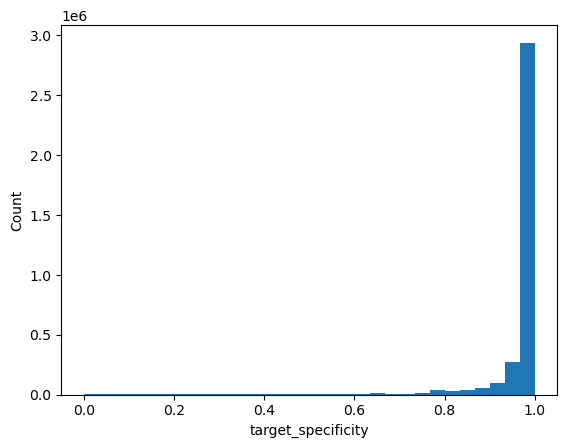

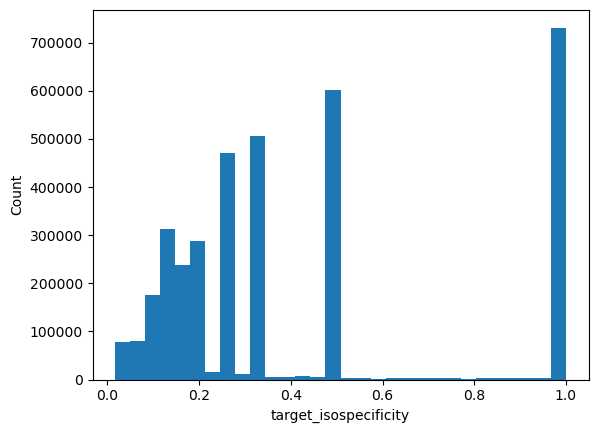

In [25]:
# Get the FPKMs of the transcripts
transcript_fpkms = dict(zip(list(transcriptome['transcript_id']), list(transcriptome['FPKM'])))

# Calculate the specificities and isoform specificities of the target regions
ot.calc_specificity(probe_dict, ottable_transcriptome, gene_ottable_dict, transcript_fpkms,
                    'target_sequence', 'target_specificity', 'target_isospecificity', 17)

plot.plot_hist(probe_dict, 'target_specificity')
plot.plot_hist(probe_dict, 'target_isospecificity')

In [26]:
# modify target isospecificity, if only one isoform exist:
for _gene, _transcript_2_df in probe_dict.items():
    if len(_transcript_2_df) == 1:
        for _transcript, _df in _transcript_2_df.items():
            probe_dict[_gene][_transcript]['target_isospecificity'] = 0.01

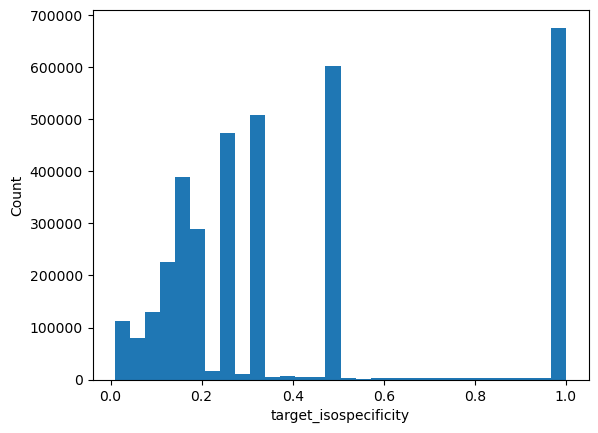

In [27]:
plot.plot_hist(probe_dict, 'target_isospecificity')

Trbc1
	ENSMUST00000192856.6: 148 / 504 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000103291.2: 104 / 453 probes passed the filter 0.99 < target_specificity <  inf.
Trbc2
	ENSMUST00000103299.3: 154 / 548 probes passed the filter 0.99 < target_specificity <  inf.
Trac
	ENSMUST00000198398.5: 507 / 653 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000103740.2: 234 / 321 probes passed the filter 0.99 < target_specificity <  inf.
Trgc1
	ENSMUST00000103558.3: 36 / 503 probes passed the filter 0.99 < target_specificity <  inf.
Trgc2
	ENSMUST00000103561.3: 41 / 501 probes passed the filter 0.99 < target_specificity <  inf.
Trgc4
	ENSMUST00000179181.3: 401 / 497 probes passed the filter 0.99 < target_specificity <  inf.
Iglc1
	ENSMUST00000200568.2: 238 / 392 probes passed the filter 0.99 < target_specificity <  inf.
Gramd3
	ENSMUST00000237355.2: 1339 / 1692 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000237422.2: 1244 / 15

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000014597.5: 1510 / 2025 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000224965.2: 372 / 568 probes passed the filter 0.99 < target_specificity <  inf.
Siglecg
	ENSMUST00000005592.7: 1250 / 2116 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000154322.8: 1861 / 3253 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000124502.8: 1861 / 3190 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000131744.2: 1950 / 3233 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000124885.2: 241 / 520 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000123042.2: 10 / 328 probes passed the filter 0.99 < target_specificity <  inf.
Il7r
	ENSMUST00000228782.2: 1096 / 1336 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000003981.6: 1107 / 1347 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000227234.2: 561 / 741 probes passed the fil

	ENSMUST00000151510.2: 211 / 272 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000137850.8: 390 / 434 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000145283.2: 435 / 500 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000232391.2: 356 / 393 probes passed the filter 0.99 < target_specificity <  inf.
Gimap1
	ENSMUST00000054368.7: 476 / 985 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000140054.3: 246 / 492 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000204168.2: 476 / 947 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000205031.2: 329 / 481 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000142703.2: 260 / 457 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000203797.2: 683 / 1099 probes passed the filter 0.99 < target_specificity <  inf.
Gimap5
	ENSMUST00000055558.6: 580 / 1394 probes passed the filter 0.99 <

	ENSMUST00000118405.2: 2457 / 3280 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000170971.8: 2507 / 3308 probes passed the filter 0.99 < target_specificity <  inf.
Dock4
	ENSMUST00000037488.8: 3992 / 4966 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000222860.2: 798 / 1075 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000222287.2: 2119 / 2525 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000221758.2: 1307 / 1615 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000223290.2: 995 / 1243 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000222798.2: 609 / 775 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000220912.2: 3806 / 4711 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000221731.2: 253 / 486 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000220783.2: 968 / 1165 probes passed the filter 0

	ENSMUST00000109546.9: 5481 / 6881 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000109543.9: 1334 / 1673 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000109544.9: 2824 / 3451 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000162715.2: 225 / 294 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000160740.8: 388 / 466 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000159285.2: 173 / 232 probes passed the filter 0.99 < target_specificity <  inf.
Il2ra
	ENSMUST00000028111.6: 1783 / 2648 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000150890.3: 388 / 582 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000195427.2: 240 / 313 probes passed the filter 0.99 < target_specificity <  inf.
Carhsp1
	ENSMUST00000008537.10: 1273 / 2187 probes passed the filter 0.99 < target_specificity <  inf.
Cd69
	ENSMUST00000032259.6: 659 / 818 probes passed the

	ENSMUST00000229616.2: 252 / 483 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000136065.2: 426 / 755 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000100013.9: 2029 / 2629 probes passed the filter 0.99 < target_specificity <  inf.
Cxcr5
	ENSMUST00000215293.2: 1983 / 2388 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000215661.2: 221 / 268 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000213357.2: 216 / 240 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000062215.8: 1811 / 2185 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000179828.8: 1957 / 2367 probes passed the filter 0.99 < target_specificity <  inf.
Map4k1
	ENSMUST00000208227.2: 1710 / 2261 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000085835.8: 1655 / 2203 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000207185.2: 1695 / 2213 probes passed the fi

	ENSMUST00000221994.2: 972 / 1327 probes passed the filter 0.99 < target_specificity <  inf.
Osbpl11
	ENSMUST00000232100.2: 2182 / 2804 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000232181.2: 2182 / 2804 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000039733.10: 2182 / 2804 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000231617.2: 898 / 1297 probes passed the filter 0.99 < target_specificity <  inf.
Ddhd1
	ENSMUST00000111828.4: 4542 / 5587 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000087320.13: 4568 / 5651 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000051310.13: 2381 / 2767 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000152110.8: 2066 / 2409 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000129599.8: 1358 / 1556 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000149286.9: 1576 / 1843 probes pas

	ENSMUST00000102601.10: 476 / 614 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000060956.13: 376 / 499 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000108662.2: 427 / 521 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000140555.2: 214 / 279 probes passed the filter 0.99 < target_specificity <  inf.
Eepd1
	ENSMUST00000040677.6: 1838 / 2145 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000156237.2: 415 / 491 probes passed the filter 0.99 < target_specificity <  inf.
Adora2a
	ENSMUST00000105420.3: 1452 / 1873 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000219044.2: 301 / 425 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000219322.2: 335 / 500 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000217703.2: 262 / 320 probes passed the filter 0.99 < target_specificity <  inf.
Hdac4
	ENSMUST00000097644.9: 4298 / 5988 probes passed the f

	ENSMUST00000207249.2: 1532 / 2069 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000103070.3: 1737 / 2218 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000128933.2: 472 / 639 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000153870.2: 325 / 335 probes passed the filter 0.99 < target_specificity <  inf.
Gna15
	ENSMUST00000147908.2: 561 / 743 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000043709.8: 1028 / 1430 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000150586.2: 426 / 563 probes passed the filter 0.99 < target_specificity <  inf.
Slc41a2
	ENSMUST00000039956.6: 2284 / 2852 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000139329.2: 134 / 206 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000154926.2: 263 / 324 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000126617.2: 169 / 199 probes passed the filter 

	ENSMUST00000134509.8: 2294 / 2836 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000125048.8: 2260 / 3170 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000135344.8: 2131 / 2578 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000131353.8: 394 / 465 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000152723.8: 2124 / 2571 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000100570.10: 1849 / 2240 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000140972.8: 1844 / 2274 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000125247.2: 273 / 315 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000199502.2: 974 / 1310 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000145294.2: 427 / 516 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000122887.2: 456 / 515 probes passed the filter 0.99 < t

	ENSMUST00000182601.8: 608 / 695 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000170849.8: 436 / 481 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000182748.8: 908 / 1037 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000182820.9: 481 / 520 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000193530.2: 596 / 825 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000068704.12: 649 / 782 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000183327.2: 206 / 209 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000194553.2: 799 / 996 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000182986.2: 225 / 291 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000231957.2: 248 / 351 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000183166.9: 425 / 492 probes passed the filter 0.99 < target_specif

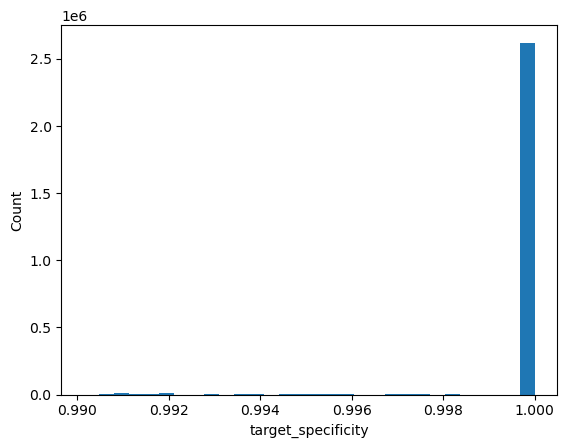

In [28]:
# Filter the specificities of the target regions
# Here we allow the probes to target other isoforms
# Don't allow any gene-level off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_specificity', lower_bound=0.99)
plot.plot_hist(probe_dict, 'target_specificity')

## Select transcript based on length / number of possible probes:

In [29]:
largest_probe_th = 1000
median_probe_th = 500


for _gene, _ts_2_pbs in probe_dict.items():
    pb_lens = []
    for _ts, _pbs in _ts_2_pbs.items():
        #print(_ts, len(_pbs))
        pb_lens.append(len(_pbs))
    if len(pb_lens) == 1:
        continue
    # filter
    if np.max(pb_lens) < largest_probe_th and np.median(pb_lens) < median_probe_th:
        print(_gene)
    #break

Trbc1
Trac
Tnfrsf13c
P2ry10
Ifng
Scoc
Clec4d
Gtf2h2
Nkg7
Phyh
Gimap1
Psmg4
Hmgn1
Parl
Ly6g
Pglyrp1
Capn3
Mettl23
Gm8369
Il17f
Alox5ap
Gsto1
Klrc2
Klrc1
Pira2
Ntpcr
Siva1
Itgam
Fam162a
Cd3d
Anapc13
Batf3
Gadd45a
Cmtm3
Svbp
Ciao2b
Il4
Ctla4
Ly6a
Ly6c1
Cyp4f16
Trappc1
Chchd10
Vpreb3
Csf3r
Gm5150
H2-Q10
Il6
Ctdnep1
Lamtor5
Arg1
Klrb1a
Mrpl54
Tmem38b
Usf1
Scimp
Gal3st4
C1qbp
Il1b
Emc6
Phospho1
Mospd3
Tnfsf13
Tnfsf12
Cd300c
BE692007
Mir99ahg
F630028O10Rik
Gm2682
Gm19585
Gm15987
Eldr
AI839979


In [30]:
# Isoform selection
sel_pb_dict = {}
largest_probe_th = 1000
isospecificity_th = 0.5
for _gene, _ts_2_pbs in probe_dict.items():
    # case 1, only one transcript
    if len(_ts_2_pbs) == 1:
        sel_pb_dict[_gene] = _ts_2_pbs
    
    pb_lens = [len(_pbs) for _ts, _pbs in _ts_2_pbs.items()]
    general_pb_lens = [np.sum(_pbs['target_isospecificity'] <= isospecificity_th) 
                       for _ts, _pbs in _ts_2_pbs.items()]
    print(pb_lens, general_pb_lens)
    #break
    # case 2, multiple transcript, now try select nonspecific probes
    # select the transcript with the most common probes
    if np.max(general_pb_lens) > largest_probe_th:
        _t = list(_ts_2_pbs.keys())[general_pb_lens.index(np.max(general_pb_lens))]
        _pbs = _ts_2_pbs[_t]
        sel_pb_dict[_gene] = {_t: _pbs[_pbs['target_isospecificity'] <= largest_probe_th]}
    # case 3: none of transcript has enough common probes: select the one with the most common probes
    elif np.max(pb_lens) > largest_probe_th:
        _t = list(_ts_2_pbs.keys())[general_pb_lens.index(np.max(general_pb_lens))]
        _pbs = _ts_2_pbs[_t]
        sel_pb_dict[_gene] = {_t: _pbs}
    # case 4: all transcripts are short, select teh longest:
    else:
        _t = list(_ts_2_pbs.keys())[pb_lens.index(np.max(pb_lens))]
        _pbs = _ts_2_pbs[_t]
        sel_pb_dict[_gene] = {_t: _pbs}
        
        # check non-specific probes
        _pbs = list(_ts_2_pbs.values())[pb_lens.index(np.max(pb_lens))]
        if np.sum(_pbs['target_isospecificity'] <= isospecificity_th) > largest_probe_th:
            _t = list(_ts_2_pbs.keys())[pb_lens.index(np.max(pb_lens))]
            sel_pb_dict[_gene] = {_t: _pbs[_pbs['target_isospecificity'] <= largest_probe_th]}  
        # select the transcript with the most common probes
    print(_t, len(sel_pb_dict[_gene][_t]))


[148, 104] [94, 94]
ENSMUST00000192856.6 148
[154] [154]
ENSMUST00000103299.3 154
[507, 234] [234, 234]
ENSMUST00000198398.5 507
[36] [36]
ENSMUST00000103558.3 36
[41] [41]
ENSMUST00000103561.3 41
[401] [401]
ENSMUST00000179181.3 401
[238] [238]
ENSMUST00000200568.2 238
[1339, 1244, 779, 1506, 1243] [1299, 1243, 732, 547, 1180]
ENSMUST00000237355.2 1339
[1181, 970, 211, 1228, 159, 384, 346, 362, 795, 514, 419, 345] [1151, 433, 206, 1113, 143, 336, 174, 307, 311, 513, 268, 98]
ENSMUST00000119694.3 1181
[229, 1313, 320, 1066] [30, 1114, 302, 1057]
ENSMUST00000219443.2 1313
[1573, 1450, 1449] [1443, 1450, 1055]
ENSMUST00000069334.8 1450
[222, 2608, 461, 288, 1401, 3156] [0, 2583, 447, 280, 1213, 2508]
ENSMUST00000025523.13 2608
[449] [449]
ENSMUST00000096065.6 449
[1507, 372, 408, 877] [409, 184, 356, 50]
ENSMUST00000021757.5 1507
[718, 781, 268, 207] [674, 676, 263, 192]
ENSMUST00000109535.3 781
[1148, 1105, 1099, 1212, 1194, 559, 461, 438, 479, 243] [1014, 1090, 1092, 1154, 1112, 503, 4

ENSMUST00000164397.8 1404
[1035, 293, 244, 186] [349, 129, 208, 37]
ENSMUST00000033662.9 1035
[3536, 196, 188] [269, 133, 136]
ENSMUST00000021201.6 3536
[742, 233, 2, 298] [37, 37, 2, 0]
ENSMUST00000050884.16 742
[230, 2231, 197, 388, 125, 467, 457, 188] [215, 826, 130, 187, 72, 459, 377, 181]
ENSMUST00000027777.12 2231
[371, 300, 289, 283, 160, 119, 33, 746, 276, 223, 195, 180, 42] [268, 300, 289, 279, 147, 19, 27, 203, 106, 173, 189, 53, 42]
ENSMUST00000123070.8 746
[2308, 801, 311] [850, 776, 127]
ENSMUST00000116436.9 2308
[5980, 1355, 713, 1045, 1622, 417] [1360, 1237, 531, 150, 144, 417]
ENSMUST00000005671.10 5980
[237, 95] [95, 95]
ENSMUST00000190262.2 237
[1037, 294] [282, 282]
ENSMUST00000041053.11 1037
[1974] [1974]
ENSMUST00000063690.4 1974
[1612, 1640, 73] [1551, 1568, 68]
ENSMUST00000138202.8 1640
[828, 121, 657, 677, 1140] [781, 52, 657, 629, 726]
ENSMUST00000054483.14 828
[2290, 242, 97, 799, 1320] [720, 220, 67, 45, 388]
ENSMUST00000079323.8 2290
[3294, 1214, 2277, 2071,

ENSMUST00000203615.3 5537
[769, 292, 1048, 239] [383, 285, 108, 95]
ENSMUST00000102832.3 769
[1004, 1018, 467, 265, 465] [920, 916, 431, 163, 455]
ENSMUST00000018361.10 1004
[2952, 2115, 2007, 195, 1370] [2088, 2091, 1807, 191, 111]
ENSMUST00000238680.2 2115
[929, 143] [124, 124]
ENSMUST00000000834.4 929
[2072, 708, 171, 365] [753, 528, 91, 134]
ENSMUST00000033053.8 2072
[180, 302, 108, 248, 582] [85, 85, 85, 85, 0]
ENSMUST00000190354.2 582
[1150, 974, 888, 560] [1020, 837, 832, 560]
ENSMUST00000165430.8 1150
[2630, 2502, 298, 2502] [2454, 2502, 289, 2502]
ENSMUST00000119076.9 2502
[2573, 409, 2148] [2103, 346, 2103]
ENSMUST00000018610.7 2573
[247, 606, 362, 186, 434] [226, 587, 355, 185, 323]
ENSMUST00000193771.6 606
[2026, 1959, 903, 666, 1278] [1998, 1958, 755, 585, 497]
ENSMUST00000037491.11 2026
[3553, 216, 373, 429, 2354, 561, 423] [2425, 188, 222, 417, 2148, 510, 394]
ENSMUST00000027517.14 3553
[648, 699] [621, 621]
ENSMUST00000126417.3 699
[1472, 879, 1055, 481, 892, 146, 423, 

ENSMUST00000186154.7 2627
[2106, 2029, 2051, 299, 2054] [2106, 2009, 2033, 100, 1990]
ENSMUST00000111785.9 2106
[19] [19]
ENSMUST00000009340.10 19
[5469, 419] [358, 358]
ENSMUST00000030010.4 5469
[402, 1593, 507, 224, 1615] [213, 1516, 418, 212, 1546]
ENSMUST00000100747.3 1615
[808, 280, 301, 268] [294, 103, 152, 188]
ENSMUST00000030127.13 808
[942, 1527, 961, 186, 1620, 258] [819, 1527, 776, 166, 1316, 246]
ENSMUST00000040250.15 1527
[1070, 595, 405, 540, 642] [630, 591, 200, 381, 458]
ENSMUST00000063084.16 1070
[1793, 1723, 1222] [1777, 1716, 68]
ENSMUST00000058790.12 1793
[1728, 1813] [1614, 1614]
ENSMUST00000084526.12 1728
[4609, 3616, 618, 497, 1618, 839, 309, 368, 356, 640] [4328, 3603, 67, 485, 926, 712, 294, 323, 190, 117]
ENSMUST00000060311.12 4609
[137, 2141, 5354, 1222, 6548, 3099, 1811, 756, 878, 253, 1760, 970, 634, 1490, 909, 853, 754, 6887] [0, 417, 5334, 1222, 6548, 1705, 851, 483, 124, 156, 978, 888, 615, 24, 125, 0, 211, 6868]
ENSMUST00000064395.13 6887
[2029, 1170, 4

In [31]:
p_d.print_probe_dict(sel_pb_dict) 
# We excluded all the transcripts that are not our direct targets

Gene	Transcript	N_probes
Trbc1
	ENSMUST00000192856.6	148
Trbc2
	ENSMUST00000103299.3	154
Trac
	ENSMUST00000198398.5	507
Trgc1
	ENSMUST00000103558.3	36
Trgc2
	ENSMUST00000103561.3	41
Trgc4
	ENSMUST00000179181.3	401
Iglc1
	ENSMUST00000200568.2	238
Gramd3
	ENSMUST00000237355.2	1339
Ctsf
	ENSMUST00000119694.3	1181
Arhgap5
	ENSMUST00000219443.2	1313
Dach1
	ENSMUST00000069334.8	1450
Csf1r
	ENSMUST00000025523.13	2608
Tigit
	ENSMUST00000096065.6	449
Aoah
	ENSMUST00000021757.5	1507
Tnfrsf13c
	ENSMUST00000109535.3	781
Nfe2
	ENSMUST00000149111.8	1212
Il12rb2
	ENSMUST00000117441.8	1291
Zfp385a
	ENSMUST00000229373.2	1150
Lyz1
	ENSMUST00000092162.7	174
Trem3
	ENSMUST00000048065.6	537
Dab2
	ENSMUST00000080880.12	2043
Cysltr1
	ENSMUST00000113480.2	1065
Trem2
	ENSMUST00000132340.2	2832
P2ry10
	ENSMUST00000053375.4	491
Fos
	ENSMUST00000140525.8	510
Jarid2
	ENSMUST00000173246.8	3181
Aicda
	ENSMUST00000043301.14	1259
Ralgapa1
	ENSMUST00000226244.2	3723
Atp8a1
	ENSMUST00000037380.15	3578
Rtcb
	ENSMUST00000

In [32]:
kept_gene_list = ['Trbc1', 'Trac', 'Ifng', 'Ly6g', 'Il17f', 'Batf3', 'Ly6c1', 'Csf3r', 'Il6', 'Arg1',
                  'Il27', 'Il17a', 'Csf2', 'Il2', 'Fos', 'Tigit']
removed_gene_list = []

for _gene,_t_2_pbs in sel_pb_dict.items():
    _pbs = list(_t_2_pbs.values())[0]
    if _gene in kept_gene_list:
        continue
    #if len(_pbs) > 600 and len(_pbs) < 650:
    #    print("_", _gene)
    
    if len(_pbs) < 600:
        print(_gene)
        removed_gene_list.append(_gene)
    else:
        kept_gene_list.append(_gene)

Trbc2
Trgc1
Trgc2
Trgc4
Iglc1
Lyz1
Trem3
P2ry10
Il22
Scoc
C1galt1c1
Clec4d
Nkg7
Tubb6
Phyh
Hpgd
Gimap5
Psmg4
Capn3
Mettl23
Klrk1
Gsto1
Klrc2
Klrc1
Pira2
Itgam
Fam162a
Anapc13
Gadd45a
Svbp
Ciao2b
Il4
Icos
Ly6a
Xcl1
Cyp4f16
Trappc1
Vpreb3
Gm5150
Trappc2l
H2-Q10
Ctdnep1
Lamtor5
Klrb1a
Pkig
Mrpl54
Ifi211
Scimp
Gal3st4
Emc6
Phospho1
Bmyc
Tnfsf13
Tnfsf12
Cd300c
Gm2682
Gm30211
AI839979


In [33]:
len(kept_gene_list)

368

## Plot outputs

In [34]:
# given these genes, re-calculate expression
target_gene_umi_frac_filename = os.path.join(library_folder, 'marker_gene_umi_frac.csv')
target_gene_umi_frac_df = pd.read_csv(target_gene_umi_frac_filename)
target_gene_umi_frac_df = target_gene_umi_frac_df.set_index(target_gene_umi_frac_df.columns[0])
target_gene_umi_frac_df.rename(index=replace_dict, inplace=True)
kept_gene_umi_frac_df = target_gene_umi_frac_df.loc[np.array(kept_gene_list)]


In [35]:
figure_folder = os.path.join(library_folder, 'figures')
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)

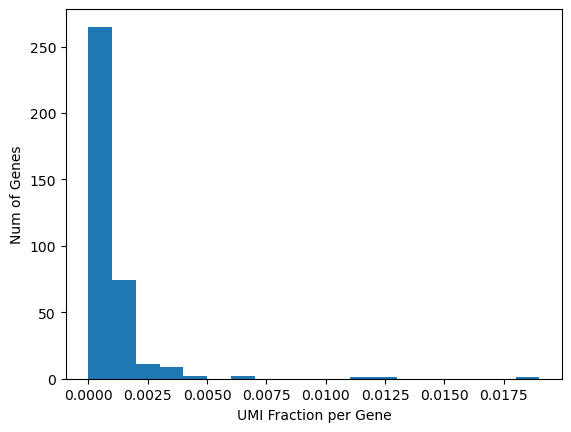

In [36]:
plt.figure()
plt.hist(np.sum(kept_gene_umi_frac_df, 1), bins=np.arange(0, 0.02, 0.001))
plt.xlabel("UMI Fraction per Gene")
plt.ylabel("Num of Genes")
plt.savefig(os.path.join(figure_folder, 
                         f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_UMI_fraction_histogram.png"), 
            transparent=True)
plt.show()

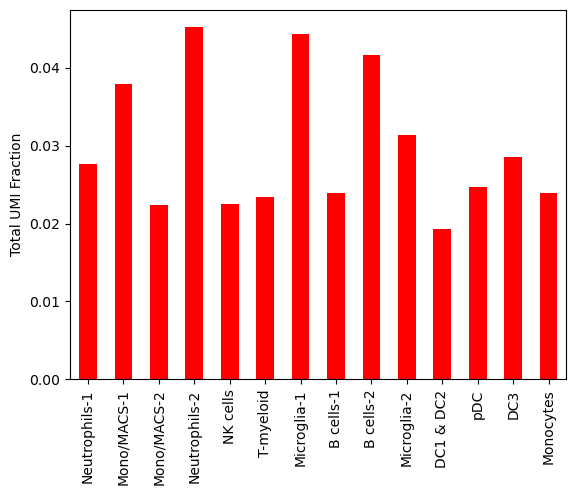

In [37]:
plt.figure()
np.sum(kept_gene_umi_frac_df, 0).plot.bar(color='red')
plt.ylabel("Total UMI Fraction")
plt.savefig(os.path.join(figure_folder, 
                         f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_Total_UMI_fraction.png"), 
            transparent=True)
plt.show()

In [38]:
len(kept_gene_list)

368

In [39]:
# further select sel_pb_dict
kept_pb_dict = {_gene:_pb for _gene, _pb in sel_pb_dict.items() if _gene in kept_gene_list}

## determine marker gene group

In [40]:
marker_gene_group_df = pd.read_csv(kept_marker_gene_filename).set_index("Gene").rename(replace_dict)
# get gene_2_group
gene_2_group = {_g:_line[0] for _g,_line in marker_gene_group_df.iterrows()}

In [41]:
group_2_genes = {_g:[] for _g in target_gene_mean_exp_df.columns}
for _gene in kept_gene_list:
    _exp = target_gene_mean_exp_df.loc[_gene]
    _group = gene_2_group[_gene]
    # update manual groups
    if _group == 'manual':
        _group = _exp.index[np.argmax(_exp)]
    group_2_genes[_group].append(_gene)
marker_gene_num_df = pd.Series({_group: len(_genes) for _group, _genes in group_2_genes.items()})

In [42]:
target_gene_mean_exp_df

,Neutrophils-1,Mono/MACS-1,Mono/MACS-2,Neutrophils-2,NK cells,T-myeloid,Microglia-1,B cells-1,B cells-2,Microglia-2,DC1 & DC2,pDC,DC3,Monocytes
gene_symbols,,,,,,,,,,,,,,
Cd19,0.020513,0.001901,0.002786,0.006024,0.006192,0.108553,0.000000,1.682203,0.507772,0.052356,0.000000,0.000000,0.000000,0.059701
Map4k1,0.090598,0.163498,0.777159,0.018072,0.185759,0.569079,0.020833,0.745763,0.139896,0.204188,1.407895,0.470588,0.197183,0.701493
Gm8369,0.029060,0.017110,0.086351,0.006024,0.077399,0.355263,0.004167,0.927966,0.300518,0.267016,0.250000,0.000000,0.014085,0.074627
Fpr1,1.100855,0.003802,0.144847,0.177711,0.018576,0.134868,0.008333,0.008475,0.020725,0.125654,0.006579,0.042017,0.056338,0.253731
Sesn1,0.049573,0.077947,0.150418,0.012048,0.176471,0.315789,0.150000,0.682203,0.476684,0.476440,0.230263,0.067227,0.084507,0.134328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Spns3,0.013675,0.007605,0.011142,0.000000,0.012384,0.029605,0.012500,0.033898,0.020725,0.094241,0.144737,0.831933,0.042254,0.000000
Lncpint,0.082051,0.313688,0.228412,0.108434,0.247678,0.342105,0.383333,0.262712,0.450777,0.335079,0.315789,0.521008,0.309859,0.343284
Pdzd4,0.005128,0.003802,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005236,0.026316,0.840336,0.000000,0.000000


In [43]:
# update gene_2_group
gene_2_group = {}
for _group, _genes in group_2_genes.items():
    for _g in _genes:
        gene_2_group[_g] = _group

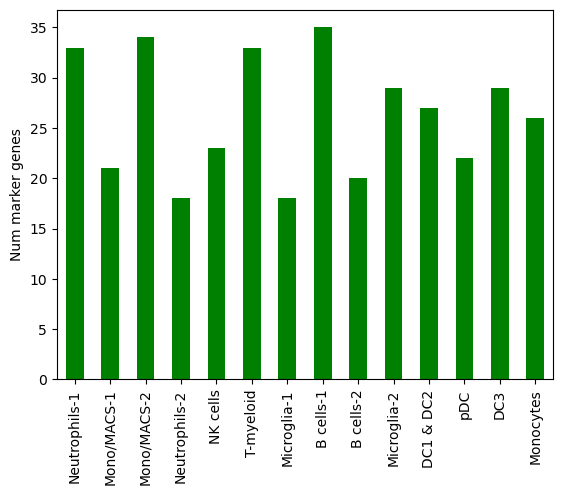

In [45]:
plt.figure()
marker_gene_num_df.plot.bar(color='green')
plt.ylabel("Num marker genes")
plt.savefig(os.path.join(figure_folder, 
                         f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_marker_gene_number.png"), 
            transparent=True)
plt.show()

## save probe_dict

In [46]:
import pickle
full_probe_filename = os.path.join(library_folder, 
                                   f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_full_probe_isoforms.pkl")
print(full_probe_filename)
pickle.dump(probe_dict, open(full_probe_filename, 'wb'))

/lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF3-msBrain_immune_redesign/2023_8_29_full_probe_isoforms.pkl


In [47]:
# candidate probes
candidate_probe_filename = os.path.join(library_folder, 
                                   f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_candidate_probe.pkl")
print(candidate_probe_filename)
pickle.dump(kept_pb_dict, open(candidate_probe_filename, 'wb'))

/lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF3-msBrain_immune_redesign/2023_8_29_candidate_probe.pkl


## restart here if applicable:

In [48]:
# Save the list of genes
kept_gene_filename = os.path.join(library_folder, 'kept_gene_info.csv')

kept_gene_info = ({'Name':kept_gene_list,
                   'Transcript': [list(sel_pb_dict[_gene].keys())[0] for _gene in kept_gene_list],
                   'Num_Candidate_Probes': [len(list(sel_pb_dict[_g].values())[0]) for _g in kept_gene_list],
                  'Group': [gene_2_group[_g] for _g in kept_gene_list],
                  }
                 )
                    
kept_gene_info = pd.DataFrame(kept_gene_info).set_index("Name")
# add info
kept_gene_info = pd.concat([kept_gene_info, target_gene_mean_exp_df.loc[kept_gene_list]], axis=1)
# save
kept_gene_info.to_csv(kept_gene_filename, index=1)

In [49]:
kept_gene_info

,Transcript,Num_Candidate_Probes,Group,Neutrophils-1,Mono/MACS-1,Mono/MACS-2,Neutrophils-2,NK cells,T-myeloid,Microglia-1,B cells-1,B cells-2,Microglia-2,DC1 & DC2,pDC,DC3,Monocytes
Trbc1,ENSMUST00000192856.6,148,NK cells,0.010256,0.005703,0.044568,0.003012,0.204334,0.259868,0.004167,0.059322,0.005181,0.130890,0.046053,0.000000,0.098592,0.059701
Trac,ENSMUST00000198398.5,507,DC1 & DC2,0.032479,0.017110,0.072423,0.000000,0.151703,0.457237,0.000000,0.055085,0.020725,0.324607,0.177632,0.000000,0.126761,0.119403
Ifng,ENSMUST00000068592.5,504,B cells-1,0.022222,0.000000,0.089136,0.015060,0.835913,0.476974,0.000000,0.029661,0.000000,0.068063,0.092105,0.000000,0.000000,0.089552
Ly6g,ENSMUST00000190262.2,237,Neutrophils-2,4.283760,0.005703,0.044568,0.210843,0.089783,0.180921,0.012500,0.012712,0.015544,0.267016,0.026316,0.000000,0.647887,0.000000
Il17f,ENSMUST00000039046.10,531,DC1 & DC2,0.000000,0.000000,0.000000,0.000000,0.000000,0.009868,0.000000,0.000000,0.000000,0.010471,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4933421O10Rik,ENSMUST00000155691.2,1642,Mono/MACS-2,0.059829,0.114068,0.153203,0.039157,0.058824,0.203947,0.495833,0.076271,0.067358,0.701571,0.151316,0.033613,0.084507,0.179104
Lncpint,ENSMUST00000230209.3,1751,Neutrophils-2,0.082051,0.313688,0.228412,0.108434,0.247678,0.342105,0.383333,0.262712,0.450777,0.335079,0.315789,0.521008,0.309859,0.343284
Gm15987,ENSMUST00000141700.2,640,pDC,0.058120,0.127376,1.125348,0.009036,0.046440,0.236842,0.004167,0.394068,0.176166,0.099476,0.815789,0.058824,0.140845,1.119403
2310001H17Rik,ENSMUST00000241201.1,1513,Neutrophils-1,0.960684,0.041825,0.395543,0.060241,0.170279,0.388158,0.012500,0.139831,0.005181,0.209424,0.184211,0.042017,0.140845,0.402985


In [50]:
kept_gene_info

,Transcript,Num_Candidate_Probes,Group,Neutrophils-1,Mono/MACS-1,Mono/MACS-2,Neutrophils-2,NK cells,T-myeloid,Microglia-1,B cells-1,B cells-2,Microglia-2,DC1 & DC2,pDC,DC3,Monocytes
Trbc1,ENSMUST00000192856.6,148,NK cells,0.010256,0.005703,0.044568,0.003012,0.204334,0.259868,0.004167,0.059322,0.005181,0.130890,0.046053,0.000000,0.098592,0.059701
Trac,ENSMUST00000198398.5,507,DC1 & DC2,0.032479,0.017110,0.072423,0.000000,0.151703,0.457237,0.000000,0.055085,0.020725,0.324607,0.177632,0.000000,0.126761,0.119403
Ifng,ENSMUST00000068592.5,504,B cells-1,0.022222,0.000000,0.089136,0.015060,0.835913,0.476974,0.000000,0.029661,0.000000,0.068063,0.092105,0.000000,0.000000,0.089552
Ly6g,ENSMUST00000190262.2,237,Neutrophils-2,4.283760,0.005703,0.044568,0.210843,0.089783,0.180921,0.012500,0.012712,0.015544,0.267016,0.026316,0.000000,0.647887,0.000000
Il17f,ENSMUST00000039046.10,531,DC1 & DC2,0.000000,0.000000,0.000000,0.000000,0.000000,0.009868,0.000000,0.000000,0.000000,0.010471,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4933421O10Rik,ENSMUST00000155691.2,1642,Mono/MACS-2,0.059829,0.114068,0.153203,0.039157,0.058824,0.203947,0.495833,0.076271,0.067358,0.701571,0.151316,0.033613,0.084507,0.179104
Lncpint,ENSMUST00000230209.3,1751,Neutrophils-2,0.082051,0.313688,0.228412,0.108434,0.247678,0.342105,0.383333,0.262712,0.450777,0.335079,0.315789,0.521008,0.309859,0.343284
Gm15987,ENSMUST00000141700.2,640,pDC,0.058120,0.127376,1.125348,0.009036,0.046440,0.236842,0.004167,0.394068,0.176166,0.099476,0.815789,0.058824,0.140845,1.119403
2310001H17Rik,ENSMUST00000241201.1,1513,Neutrophils-1,0.960684,0.041825,0.395543,0.060241,0.170279,0.388158,0.012500,0.139831,0.005181,0.209424,0.184211,0.042017,0.140845,0.402985


In [51]:
# save removed genes
removed_gene_filename = os.path.join(library_folder, 'removed_genes.csv')
pd.DataFrame({'Name':removed_gene_list}).to_csv(removed_gene_filename, index=None)

In [52]:
kept_gene_info

,Transcript,Num_Candidate_Probes,Group,Neutrophils-1,Mono/MACS-1,Mono/MACS-2,Neutrophils-2,NK cells,T-myeloid,Microglia-1,B cells-1,B cells-2,Microglia-2,DC1 & DC2,pDC,DC3,Monocytes
Trbc1,ENSMUST00000192856.6,148,NK cells,0.010256,0.005703,0.044568,0.003012,0.204334,0.259868,0.004167,0.059322,0.005181,0.130890,0.046053,0.000000,0.098592,0.059701
Trac,ENSMUST00000198398.5,507,DC1 & DC2,0.032479,0.017110,0.072423,0.000000,0.151703,0.457237,0.000000,0.055085,0.020725,0.324607,0.177632,0.000000,0.126761,0.119403
Ifng,ENSMUST00000068592.5,504,B cells-1,0.022222,0.000000,0.089136,0.015060,0.835913,0.476974,0.000000,0.029661,0.000000,0.068063,0.092105,0.000000,0.000000,0.089552
Ly6g,ENSMUST00000190262.2,237,Neutrophils-2,4.283760,0.005703,0.044568,0.210843,0.089783,0.180921,0.012500,0.012712,0.015544,0.267016,0.026316,0.000000,0.647887,0.000000
Il17f,ENSMUST00000039046.10,531,DC1 & DC2,0.000000,0.000000,0.000000,0.000000,0.000000,0.009868,0.000000,0.000000,0.000000,0.010471,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4933421O10Rik,ENSMUST00000155691.2,1642,Mono/MACS-2,0.059829,0.114068,0.153203,0.039157,0.058824,0.203947,0.495833,0.076271,0.067358,0.701571,0.151316,0.033613,0.084507,0.179104
Lncpint,ENSMUST00000230209.3,1751,Neutrophils-2,0.082051,0.313688,0.228412,0.108434,0.247678,0.342105,0.383333,0.262712,0.450777,0.335079,0.315789,0.521008,0.309859,0.343284
Gm15987,ENSMUST00000141700.2,640,pDC,0.058120,0.127376,1.125348,0.009036,0.046440,0.236842,0.004167,0.394068,0.176166,0.099476,0.815789,0.058824,0.140845,1.119403
2310001H17Rik,ENSMUST00000241201.1,1513,Neutrophils-1,0.960684,0.041825,0.395543,0.060241,0.170279,0.388158,0.012500,0.139831,0.005181,0.209424,0.184211,0.042017,0.140845,0.402985


# PAUSE HERE, go to jupyter-3 to design codebook